# STATS 507 Final Project  
# Modeling Medical Insurance Costs

Author: Zixun Zhang

# 1. Introduction

The goal of this project is to model annual medical insurance costs using demographic and health-related variables. Medical cost data are typically right-skewed, strictly positive, and driven by significant risk factors such as age, BMI, and smoking status. Understanding the factors that influence medical expenditures is important both for statistical modeling and actuarial applications.

In this project, we explore several regression modeling strategies:
- Ordinary Least Squares (OLS)
- Log-transformed OLS
- Gamma Generalized Linear Model (GLM) with a log link

We compare these models and identify which provides the most appropriate fit for right-skewed medical cost data.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 2. Source of Data

The dataset used in this project is the well-known *Medical Cost Personal Dataset*, which contains 1,338 observations of individual-level health and demographic information. The variables include:

- **age** — age of the individual  
- **bmi** — body mass index  
- **children** — number of dependents  
- **sex** — male or female  
- **smoker** — yes or no  
- **region** — one of four U.S. regions  
- **charges** — annual medical insurance cost (response variable)

This dataset is frequently used for illustrating regression modeling concepts because it contains clear relationships, nonlinear interactions, and a naturally right-skewed response distribution.

In [2]:
df = pd.read_csv("hf://datasets/Datasetssickness/MedicalCost/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# The basic structure and types of original data
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max

# 3. Exploratory Data Analysis

Before fitting any models, we examine the structure of the dataset and visualize key relationships between predictors and medical charges. In particular, we focus on understanding:

- the distribution of charges,  
- how charges differ by sex, smoker status, and region,  
- how continuous predictors (age, BMI, children) relate to charges,  
- whether interactions may be present.

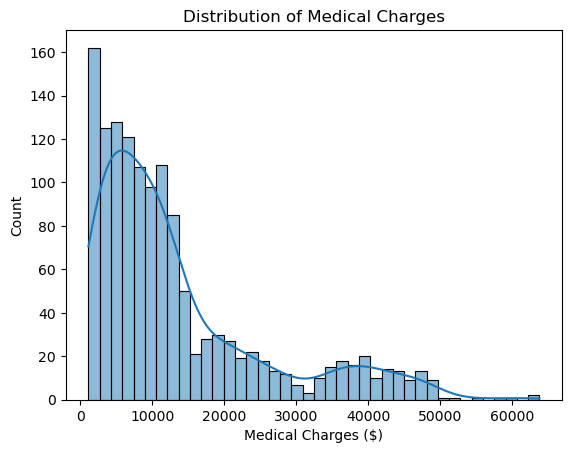

In [4]:
# The distribution of charges
sns.histplot(data=df, x='charges', bins=40, kde=True)
plt.xlabel("Medical Charges ($)")
plt.ylabel("Count")
plt.title("Distribution of Medical Charges")
plt.savefig("charge_dist.pdf", format="pdf", bbox_inches="tight")
plt.show()

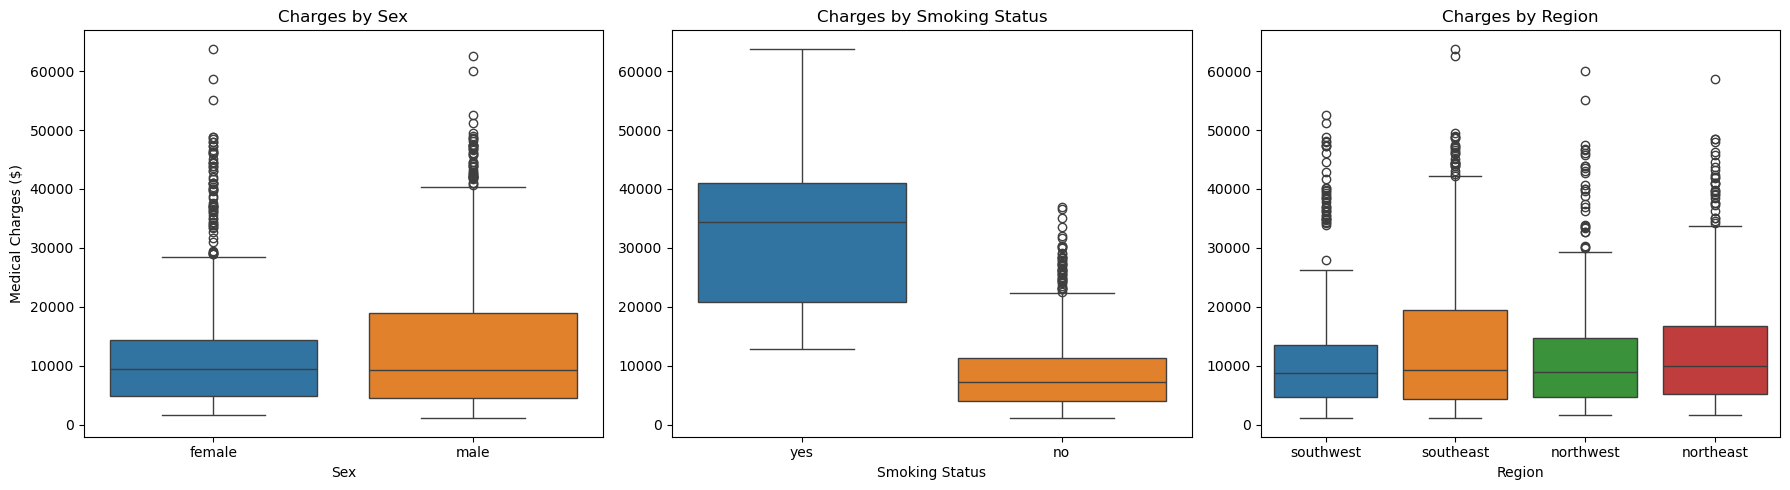

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Boxplot 1: sex
sns.boxplot(ax=axes[0], x="sex", y="charges", data=df, hue="sex")
axes[0].set_title("Charges by Sex")
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Medical Charges ($)")

# Boxplot 2: smoker
sns.boxplot(ax=axes[1], x="smoker", y="charges", data=df, hue="smoker")
axes[1].set_title("Charges by Smoking Status")
axes[1].set_xlabel("Smoking Status")
axes[1].set_ylabel("")

# Boxplot 3: region
sns.boxplot(ax=axes[2], x="region", y="charges", data=df, hue="region")
axes[2].set_title("Charges by Region")
axes[2].set_xlabel("Region")
axes[2].set_ylabel("")

plt.tight_layout()
plt.savefig("three_boxplots.pdf", format="pdf", bbox_inches="tight")
plt.show()

## 3.1 Interaction Term Justification

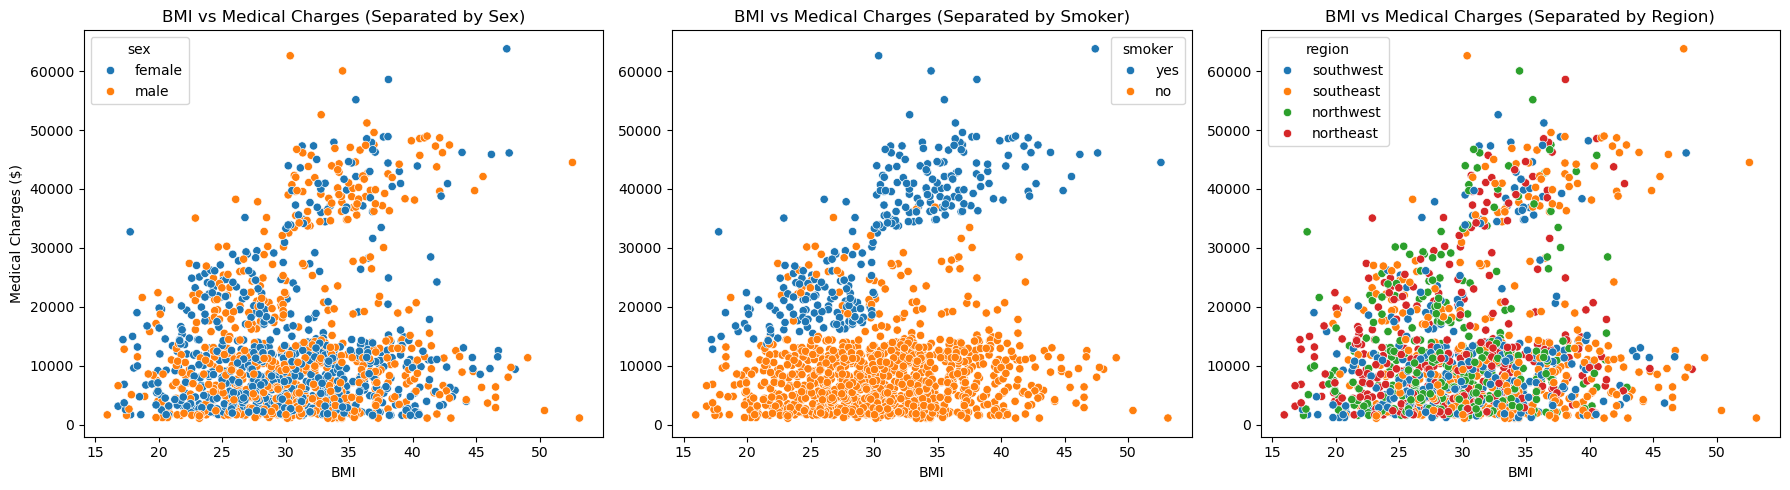

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Scatterplot 1: sex
sns.scatterplot(ax=axes[0], x="bmi", y="charges", data=df, hue="sex")
axes[0].set_title("BMI vs Medical Charges (Separated by Sex)")
axes[0].set_xlabel("BMI")
axes[0].set_ylabel("Medical Charges ($)")

# Scatterplot 2: smoker
sns.scatterplot(ax=axes[1], x="bmi", y="charges", data=df, hue="smoker")
axes[1].set_title("BMI vs Medical Charges (Separated by Smoker)")
axes[1].set_xlabel("BMI")
axes[1].set_ylabel("")

# Scatterplot 3: region
sns.scatterplot(ax=axes[2], x="bmi", y="charges", data=df, hue="region")
axes[2].set_title("BMI vs Medical Charges (Separated by Region)")
axes[2].set_xlabel("BMI")
axes[2].set_ylabel("")

plt.tight_layout()
plt.savefig("bmi_charges_interaction.pdf", format="pdf", bbox_inches="tight")
plt.show()

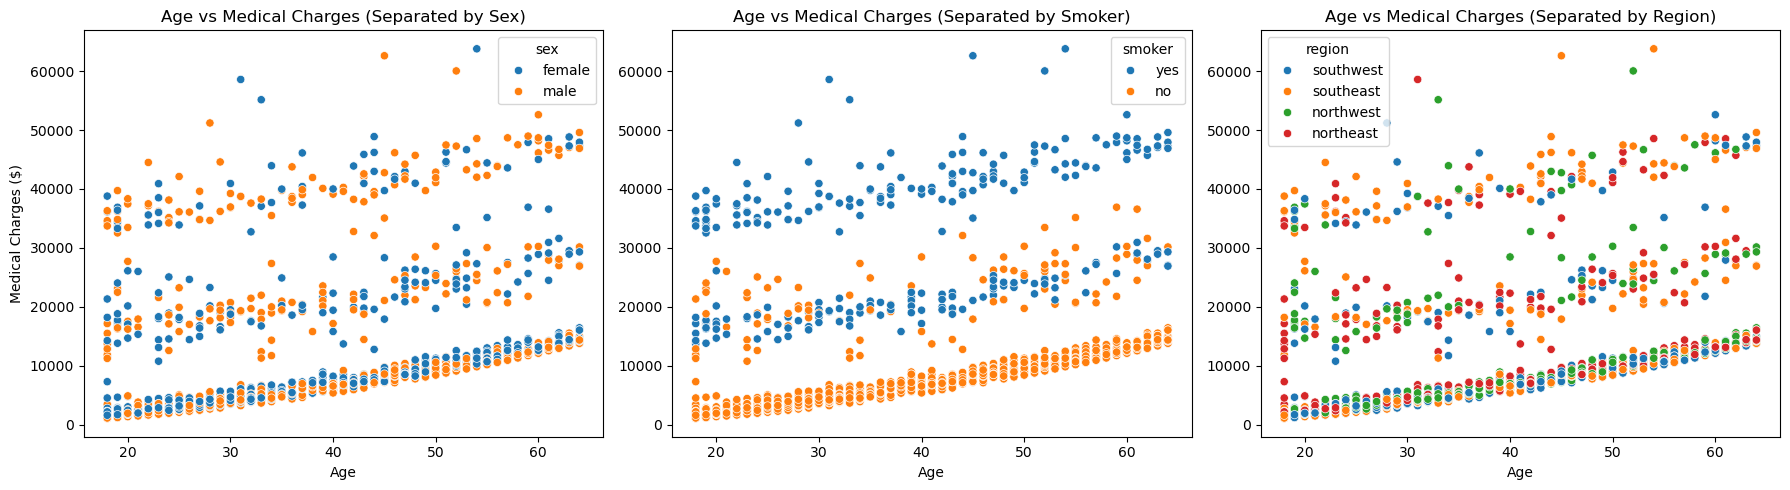

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Scatterplot 1: sex
sns.scatterplot(ax=axes[0], x="age", y="charges", data=df, hue="sex")
axes[0].set_title("Age vs Medical Charges (Separated by Sex)")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Medical Charges ($)")

# Scatterplot 2: smoker
sns.scatterplot(ax=axes[1], x="age", y="charges", data=df, hue="smoker")
axes[1].set_title("Age vs Medical Charges (Separated by Smoker)")
axes[1].set_xlabel("Age")
axes[1].set_ylabel("")

# Scatterplot 3: region
sns.scatterplot(ax=axes[2], x="age", y="charges", data=df, hue="region")
axes[2].set_title("Age vs Medical Charges (Separated by Region)")
axes[2].set_xlabel("Age")
axes[2].set_ylabel("")

plt.tight_layout()
plt.savefig("age_charges_interaction.pdf", format="pdf", bbox_inches="tight")
plt.show()

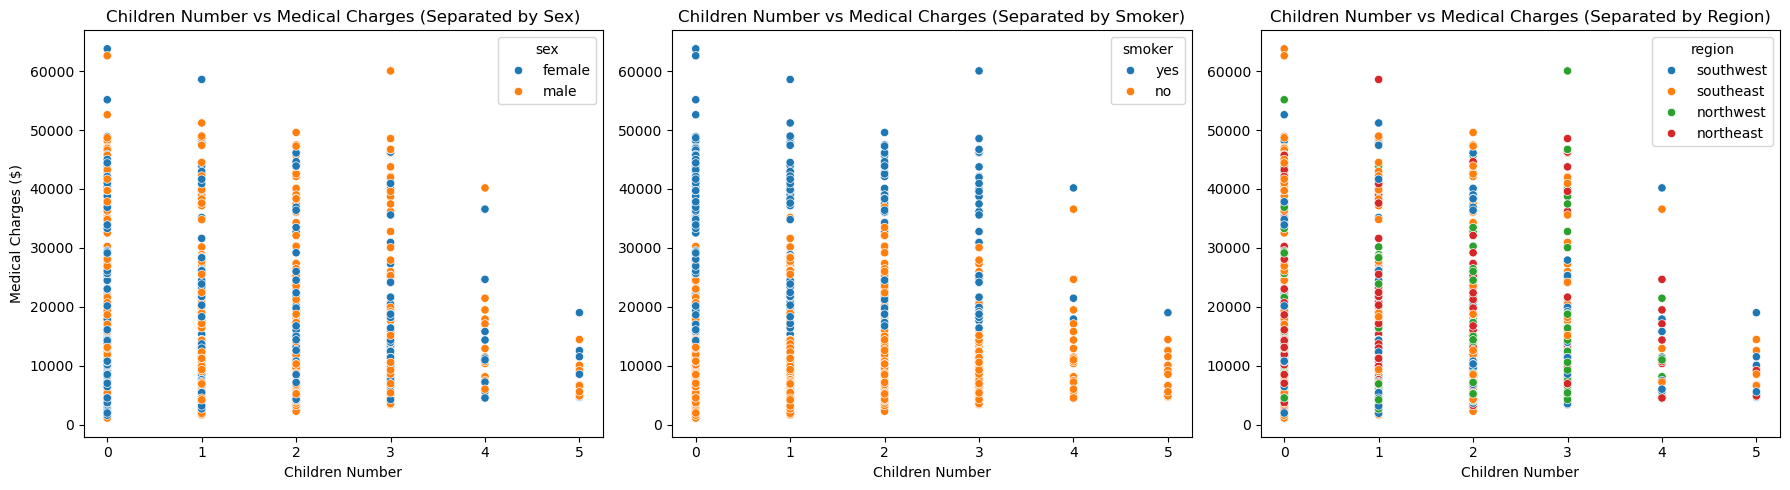

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Scatterplot 1: sex
sns.scatterplot(ax=axes[0], x="children", y="charges", data=df, hue="sex")
axes[0].set_title("Children Number vs Medical Charges (Separated by Sex)")
axes[0].set_xlabel("Children Number")
axes[0].set_ylabel("Medical Charges ($)")

# Scatterplot 2: smoker
sns.scatterplot(ax=axes[1], x="children", y="charges", data=df, hue="smoker")
axes[1].set_title("Children Number vs Medical Charges (Separated by Smoker)")
axes[1].set_xlabel("Children Number")
axes[1].set_ylabel("")

# Scatterplot 3: region
sns.scatterplot(ax=axes[2], x="children", y="charges", data=df, hue="region")
axes[2].set_title("Children Number vs Medical Charges (Separated by Region)")
axes[2].set_xlabel("Children Number")
axes[2].set_ylabel("")

plt.tight_layout()
plt.savefig("children_charges_interaction.pdf", format="pdf", bbox_inches="tight")
plt.show()

Scatterplots of BMI versus medical charges, separated by smoking status, reveal that smokers and non-smokers exhibit very different relationships. 

- For non-smokers, charges increase only slightly with BMI.  
- For smokers, charges increase sharply as BMI rises.

This indicates a strong **interaction effect**, where the slope of the BMI–charges relationship depends on smoking status. To capture this effect, we include the interaction term:

$$
\text{bmi\_smoker} = \text{BMI} \times \text{smoker}
$$

Including the interaction term allows the model to assign different slopes for smokers and non-smokers, which aligns with the observed data pattern.

## 3.2 Dummy Variable Creation

Categorical predictors such as `sex`, `smoker`, and `region` are encoded into dummy variables using `pd.get_dummies()`. To avoid multicollinearity, we drop the first category from each factor, producing:

- `male`  
- `smoker`  
- `northwest`, `southeast`, `southwest`

These binary indicators are used in all regression models. Boolean columns are converted to 0/1 when needed for numerical modeling or VIF analysis.

In [9]:
print(df['sex'].unique(), len(df['sex'].unique()))
print(df['smoker'].unique(), len(df['smoker'].unique()))
print(df['region'].unique(), len(df['region'].unique()))

['female' 'male'] 2
['yes' 'no'] 2
['southwest' 'southeast' 'northwest' 'northeast'] 4


In [10]:
categorical_cols = ['sex', 'smoker', 'region']

df_clean = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_clean.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [11]:
df_clean = df_clean.rename(columns={
    'sex_male': 'male',
    'smoker_yes': 'smoker',
    'region_northwest': 'northwest',
    'region_southeast': 'southeast',
    'region_southwest': 'southwest'
})

bool_cols = ["male", "smoker", "northwest", "southeast", "southwest"]
df_clean[bool_cols] = df_clean[bool_cols].astype(int)

df_clean.head()

,age,bmi,children,charges,male,smoker,northwest,southeast,southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [12]:
# Check for missing values
print(df_clean.isnull().sum())

age          0
bmi          0
children     0
charges      0
male         0
smoker       0
northwest    0
southeast    0
southwest    0
dtype: int64


# 4. Modeling and Diagnostics

We evaluate three regression approaches:

1. **Ordinary Least Squares (OLS)**  
2. **OLS with log-transformed response**  
3. **Gamma GLM with log link**

Each model is examined using coefficient significance, appropriate diagnostics, and interpretability.

## 4.1 Ordinary Least Squares (OLS) Model

We begin by fitting a standard multiple linear regression model using **medical charges** as the response variable and all predictors, including the BMI–smoker interaction, as explanatory variables:

$$
\text{charges} = \beta_0 + \beta_1\text{age} + \beta_2\text{bmi} + \beta_3\text{children} + \beta_4\text{male} +
\beta_5\text{smoker} + \beta_6\text{region indicators} + \beta_7(\text{bmi} \times \text{smoker}) + \varepsilon.
$$

In [13]:
base_model = smf.ols(
    formula="charges ~ age + bmi + children + male + smoker + northwest + southeast + southwest + bmi:smoker",
    data=df_clean
).fit()

base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     780.0
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:28:00   Log-Likelihood:                -13248.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1328   BIC:                         2.657e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2223.4539    865.611     -2.569      0.010   -3921.569    -525.339
age          263.6202      9.516     27.703      0.000     244.952     282.288
bmi           23.5329     25.601      0.919      0.358     -26.689      73.755
children     516.4034    110.179      4.687      0.000     300.259     732.548
male        -500.1460    266.518     -1.877      0.061   -1022.987      22.695
smoker     -2.042e+04   1648.277    -12.386      0.000   -2.36e+04   -1.72e+04
northwest   -585.4780    380.859     -1.537      0.124   -1332.630     161.674
southeast  -1210.1312    382.750     -3.162      0.002   -1960.992    -459.270
southwest  -1231.1077    382.218     -3.221      0.001   -1980.924    -481.291
bmi:smoker  1443.0964     52.647     27.411      0.000    1339.816    1546.377
==============================================================================
Omnibus:                      721.596   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4465.236
Skew:                           2.529   Prob(JB):                         0.00
Kurtosis:                      10.384   Cond. No.                         663.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The OLS summary output shows:

- **age** and **children** are strong positive predictors of medical charges.  
- **smoker** has a very large significant effect, increasing charges by roughly \$20,000 on average.  
- The **BMI × smoker interaction** is highly significant, confirming that the effect of BMI differs sharply between smokers and non-smokers.  
- Several region indicators are significantly lower than the baseline region.  
- Some predictors (e.g., BMI alone, northwest region) have non-significant coefficients.

Despite good explanatory power, OLS residuals exhibit:

- strong right-skewness,  
- heavy tails, and  
- clear evidence of heteroskedasticity.

These findings suggest that OLS assumptions are violated, limiting the reliability of inference.  
To further assess the stability of the model coefficients, we next examine **Variance Inflation Factors (VIFs)** for multicollinearity.

### 4.1.1 Variance Inflation Factor (VIF)

To evaluate potential multicollinearity among the predictors, we compute the **Variance Inflation Factor (VIF)** for each variable.  
A VIF greater than 10 is commonly used as a rule-of-thumb indicator of problematic multicollinearity.

In [14]:
df_clean["bmi_smoker"] = df_clean["bmi"] * df_clean["smoker"]

X = df_clean[[
    "age",
    "bmi",
    "children",
    "male",
    "smoker",
    "northwest",
    "southeast",
    "southwest",
    "bmi_smoker"
]]

In [15]:
X

,age,bmi,children,male,smoker,northwest,southeast,southwest,bmi_smoker
0,19,27.900,0,0,1,0,0,1,27.90
1,18,33.770,1,1,0,0,1,0,0.00
2,28,33.000,3,1,0,0,1,0,0.00
3,33,22.705,0,1,0,1,0,0,0.00
4,32,28.880,0,1,0,1,0,0,0.00
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,1,0,1,0,0,0.00
1334,18,31.920,0,0,0,0,0,0,0.00
1335,18,36.850,0,0,0,0,1,0,0.00
1336,21,25.800,0,0,0,0,0,1,0.00


In [16]:
vif = pd.DataFrame({
    "variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

vif

,variable,VIF
0,age,7.967081
1,bmi,11.927141
2,children,1.816137
3,male,2.003324
4,smoker,26.142453
5,northwest,1.902505
6,southeast,2.265575
7,southwest,1.965126
8,bmi_smoker,26.449670


Most variables (children, male, region dummies) have VIF < 3, indicating low correlation and no concern. Age has a moderate VIF (~8), which is acceptable and does not affect model stability.

Higher VIF values are observed for BMI, smoker, and the BMI×smoker interaction. These elevated values are expected because interaction terms are inherently correlated with their component variables. This does not indicate harmful multicollinearity. The regression coefficients remain stable and significant, and the model performs well overall.

### 4.1.2 Reduced OLS Model (Dropping a Marginal Predictor)


In the original OLS model, the **northwest** region indicator had a borderline p-value and was not statistically significant at the 5% level.  
To evaluate whether removing this variable improves the model, we fit a reduced OLS model excluding `northwest`:

$$
\text{charges} = \beta_0 + \beta_1\text{age} + \beta_2\text{bmi} + \beta_3\text{children} + 
\beta_4\text{male} + \beta_5\text{smoker} + \beta_6\text{southeast} +
\beta_7\text{southwest} + \beta_8(\text{bmi} \times \text{smoker}) + \varepsilon.
$$

In [17]:
reduced_model = smf.ols(
    formula="charges ~ age + bmi + children + male + smoker + southeast + southwest + bmi:smoker",
    data=df_clean
).fit()

reduced_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     876.3
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:28:00   Log-Likelihood:                -13249.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1329   BIC:                         2.656e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2527.2224    843.187     -2.997      0.003   -4181.345    -873.100
age          263.6678      9.521     27.694      0.000     244.991     282.345
bmi           23.8816     25.613      0.932      0.351     -26.364      74.127
children     511.3184    110.186      4.640      0.000     295.161     727.476
male        -497.9827    266.650     -1.868      0.062   -1021.084      25.119
smoker     -2.035e+04   1648.533    -12.343      0.000   -2.36e+04   -1.71e+04
southeast   -917.6484    332.281     -2.762      0.006   -1569.501    -265.796
southwest   -937.2771    331.162     -2.830      0.005   -1586.935    -287.619
bmi:smoker  1441.2939     52.661     27.369      0.000    1337.986    1544.601
==============================================================================
Omnibus:                      717.904   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4395.150
Skew:                           2.517   Prob(JB):                         0.00
Kurtosis:                      10.314   Cond. No.                         661.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
bool(reduced_model.aic < base_model.aic)

False

### **Comparison with the Original OLS Model**

Removing the northwest indicator results in:

- The **same R-squared** (0.841), indicating that explanatory power did not improve.  
- Slightly **worse AIC**, meaning the reduced model fits the data **less well** from a likelihood perspective.  
- Other coefficients remain almost unchanged, reflecting the weak unique contribution of the northwest variable.

### 4.1.3 OLS Residual Diagnostics

Ordinary Least Squares regression relies on several key assumptions:

1. **Linearity** — The relationship between predictors and the response is linear.  
2. **Independence** — Observations are independent of each other.  
3. **Homoskedasticity** — The variance of the errors is constant across fitted values.  
4. **Normality of residuals** — The error terms follow a normal distribution.

To evaluate whether these assumptions hold for the medical charges dataset, we examine two diagnostic plots:  
(1) the Residuals vs Fitted plot, and  
(2) the Normal Q–Q plot.

#### **Residuals vs Fitted Plot**

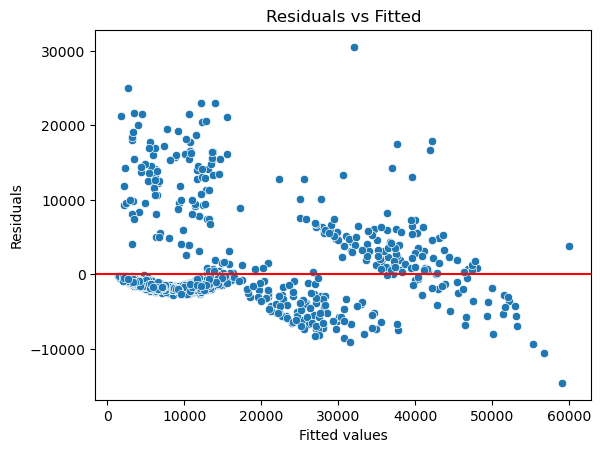

In [19]:
sns.scatterplot(x=base_model.fittedvalues, y=base_model.resid)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.savefig("ols_residual_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

This plot reveals several clear violations of OLS assumptions:

- A pronounced **funnel shape**, with residual variance increasing as fitted values increase.  
  → This indicates **heteroskedasticity** (violates Assumption 3).  
- A curved, non-random pattern in the residuals.  
  → Suggests **nonlinearity** in the predictor–response relationship (violates Assumption 1).  
- Distinct clusters corresponding to smokers and non-smokers.  
  → Implies different variance structures among subgroups.

Overall, the residuals show that the OLS model does not adequately capture mean–variance relationships in the data.

#### **Normal Q–Q Plot**

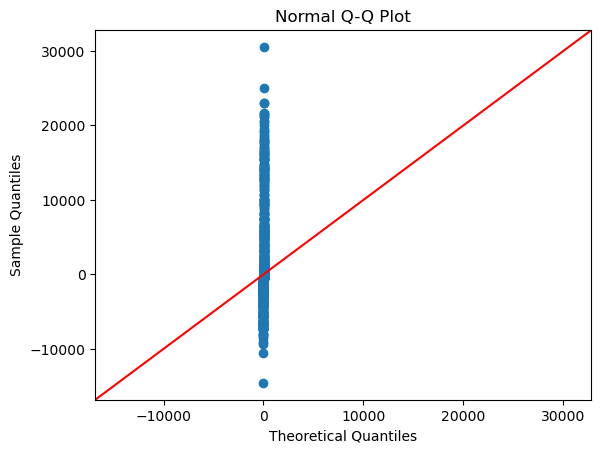

In [20]:
sm.qqplot(base_model.resid, line='45')
plt.title("Normal Q-Q Plot")
plt.savefig("ols_qq_plt.pdf", format="pdf", bbox_inches="tight")
plt.show()

The Q–Q plot demonstrates extremely severe deviations from normality:

- Almost all points appear along a vertical band rather than following the diagonal.  
- The upper tail contains extremely large residuals due to high-cost observations.  
- The distribution exhibits **substantial right-skewness** and **heavy tails**.

This strongly violates **Assumption 4 (Normality of residuals)** and confirms that OLS inference (t-tests, confidence intervals) may be unreliable.

### 4.1.4 Outlier and Influence Analysis

Because medical cost data often contain extremely high-cost individuals, it is important to assess whether certain observations exert disproportionate influence on the OLS model.  
We use **Cook’s Distance**, a standard influence measure defined as:

$$
D_i = \frac{\sum_{j=1}^{n}(\hat{y}_j - \hat{y}_{j(i)})^2}{p \cdot \hat{\sigma}^2},
$$

where $$\hat{y}_{j(i)}$$ is the fitted value with observation \(i\) removed.

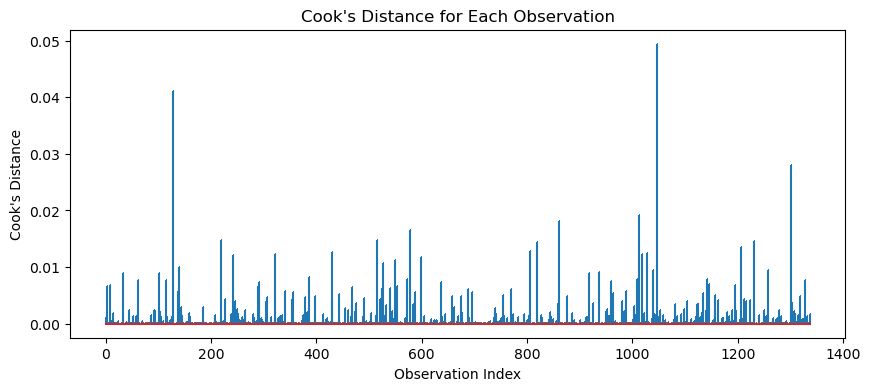

In [21]:
influence = base_model.get_influence()
cooks_d, pvals = influence.cooks_distance

plt.figure(figsize=(10,4))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt=",")
plt.title("Cook's Distance for Each Observation")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.savefig("cook_distance.pdf", format="pdf", bbox_inches="tight")
plt.show()

The plot of Cook’s Distance across all 1,338 observations shows:

- Several observations with noticeably larger influence values than the rest.  
- However, the maximum Cook’s Distance is below **0.05**, far below common heuristic thresholds such as:
  - $D_i$ > 1, or  
  - $D_i$ > $\frac{4}{n}$ $\approx$ 0.003\) (a very conservative rule).

Using the conservative threshold \(4/n\), many observations technically qualify as influential because of the heavy-tailed cost distribution. This behavior is typical in healthcare expenditure data and does not necessarily indicate problematic points.

### **Conclusion of OLS Diagnostics**

The diagnostic evidence reveals multiple serious violations of OLS assumptions:

- **Nonlinearity**  
- **Heteroskedasticity**  
- **Extremely non-normal residual distribution**  
- **Presence of influential high-cost observations**

Although OLS provides interpretable coefficients and a high \(R^2\), these violations indicate that the OLS framework is poorly suited for modeling highly skewed medical cost data.

These shortcomings motivate the use of alternative models, such as a log-transformed response or a Gamma GLM with log link.

## 4.2 Log-Transformed OLS Model

Because medical charges are highly right-skewed with extreme high-cost observations, we next apply a **log transformation** to the response:

$$
\log(\text{charges}) = X\beta + \varepsilon.
$$

The log transformation serves two purposes:

1. **Reduces right-skewness** of the response distribution.
2. **Stabilizes variance**, making heteroskedasticity less severe.

We fit the model using the same set of predictors, including the BMI–smoker interaction.

In [22]:
log_model = smf.ols(
    formula="np.log(charges) ~ age + bmi + children + male + smoker + northwest + southeast + southwest + bmi:smoker", 
    data=df_clean
).fit()

log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(charges)   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     534.0
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:28:00   Log-Likelihood:                -762.05
No. Observations:                1338   AIC:                             1544.
Df Residuals:                    1328   BIC:                             1596.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3374      0.077     95.697      0.000       7.187       7.488
age            0.0348      0.001     41.281      0.000       0.033       0.036
bmi            0.0034      0.002      1.502      0.133      -0.001       0.008
children       0.1031      0.010     10.569      0.000       0.084       0.122
male          -0.0871      0.024     -3.688      0.000      -0.133      -0.041
smoker         0.1564      0.146      1.071      0.284      -0.130       0.443
northwest     -0.0711      0.034     -2.108      0.035      -0.137      -0.005
southeast     -0.1627      0.034     -4.800      0.000      -0.229      -0.096
southwest     -0.1375      0.034     -4.062      0.000      -0.204      -0.071
bmi:smoker     0.0456      0.005      9.773      0.000       0.036       0.055
==============================================================================
Omnibus:                      520.045   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2150.321
Skew:                           1.846   Prob(JB):                         0.00
Kurtosis:                       7.994   Cond. No.                         663.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### **Coefficient Interpretation**

In the log-model:

- A coefficient $\beta_j$ corresponds to a **multiplicative** effect on expected charges.  
- Specifically, a one-unit increase in predictor $x_j$ changes expected charges by  
  $$
  \exp(\beta_j) - 1,
  $$
  expressed as a percentage.

Key observations from the coefficient table:

- **age**, **children**, and **male** remain significant.  
- **smoker** alone is no longer significant, but  
- The **BMI × smoker** interaction remains highly significant, suggesting that smoking amplifies the effect of BMI on costs.
- Region effects (`southeast`, `southwest`) remain significantly negative relative to the baseline region.

### **Model Fit**

- AIC for the log-model is **much lower (1544)** than the AIC for the raw OLS model (~26520).  
  This indicates an improved likelihood-based fit **on the transformed scale**.
- $R^2 = 0.784$, which should **not** be directly compared to the R² of the untransformed model because the response scale has changed.

## **4.2.1 Residual Diagnostics for Log-OLS**

Even after transformation, we must verify whether the linear model assumptions are met on the log scale.

### **Residuals vs Fitted Plot**

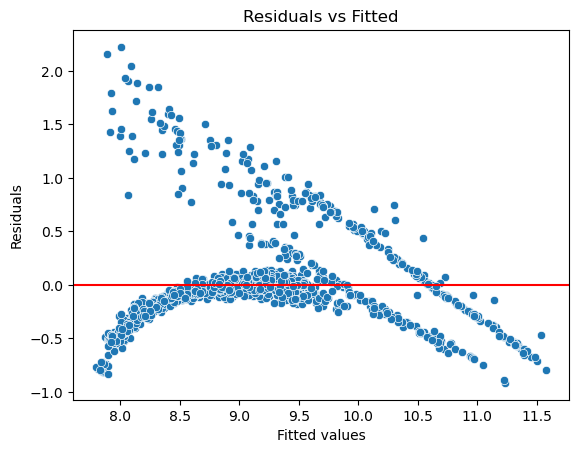

In [23]:
sns.scatterplot(x=log_model.fittedvalues, y=log_model.resid)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.savefig("log_residual_plt.pdf", format="pdf", bbox_inches="tight")
plt.show()

The residual plot shows:

- A persistent **curved pattern**, indicating remaining **nonlinearity**.  
- Residuals still fan out at higher fitted log-charges, suggesting **residual heteroskedasticity**.  
- Two distinct bands of residuals corresponding to smokers and non-smokers, indicating subgroup-specific effects not fully captured by the model.

Although the log transformation improves the structure somewhat, it does **not fully resolve** the mean–variance relationship.

### **Normal Q–Q Plot**

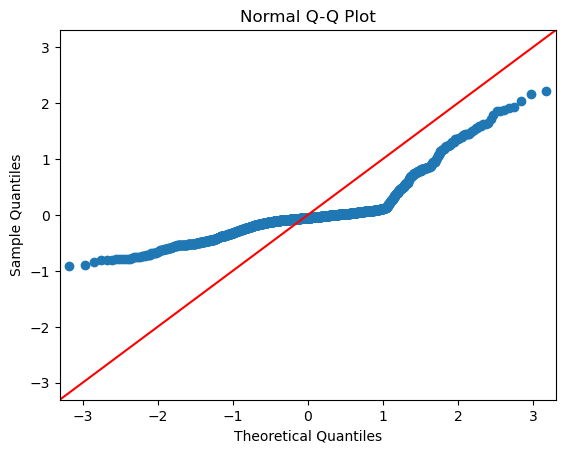

In [24]:
sm.qqplot(log_model.resid, line='45')
plt.title("Normal Q-Q Plot")
plt.savefig("log_qq_plt.pdf", format="pdf", bbox_inches="tight")
plt.show()

The Q–Q plot improves noticeably compared to the raw OLS model:

- The central region of the residual distribution is now closer to the 45° reference line.  
- However, substantial deviations remain in both tails.  
- The upper tail remains heavy, reflecting that even log-transformed medical costs retain considerable skewness.

These results indicate that **normality of residuals remains violated**, though less severely than before.

### **Conclusion for Log-Model**

The log-transformed OLS model:

- improves distributional shape,  
- produces a much lower AIC,  
- and slightly improves residual normality.

However:

- nonlinearity,  
- heteroskedasticity,  
- and heavy-tailed behavior  

are still present.

These persistent issues suggest that even after transformation, a Gaussian error structure is not fully appropriate for medical cost data.  
This motivates the use of a **Gamma GLM**, which is designed for skewed, positive responses with variance proportional to the mean.

## 4.3 Gamma GLM with Log Link

Because medical expenditures are strictly positive and strongly right-skewed, we next fit a **Gamma Generalized Linear Model (GLM)** with a **log link**, a standard approach in actuarial science and health economics.

A Gamma GLM assumes:

$$
Y \sim \text{Gamma}(\mu, \phi), \qquad \log(\mu) = X\beta.
$$

This model naturally accommodates:
- **positive-valued responses**,  
- **skewness**, and  
- **variance increasing with the mean**,  

all of which reflect the empirical characteristics of medical cost data.

In [25]:
gamma_model = smf.glm(
    formula="charges ~ age + bmi + children + male + smoker + northwest + southeast + southwest + bmi:smoker",
    data=df_clean,
    family=sm.families.Gamma(sm.families.links.Log())
).fit()

gamma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                charges   No. Observations:                 1338
Model:                            GLM   Df Residuals:                     1328
Model Family:                   Gamma   Df Model:                            9
Link Function:                    Log   Scale:                         0.45296
Method:                          IRLS   Log-Likelihood:                -13277.
Date:                Mon, 08 Dec 2025   Deviance:                       320.28
Time:                        18:28:00   Pearson chi2:                     602.
No. Iterations:                    17   Pseudo R-squ. (CS):             0.7030
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6947      0.120     64.011      0.000       7.459       7.930
age            0.0290      0.001     21.965      0.000       0.026       0.032
bmi            0.0039      0.004      1.088      0.277      -0.003       0.011
children       0.0852      0.015      5.569      0.000       0.055       0.115
male          -0.0681      0.037     -1.841      0.066      -0.141       0.004
smoker         0.0388      0.229      0.169      0.865      -0.410       0.487
northwest     -0.0661      0.053     -1.250      0.211      -0.170       0.038
southeast     -0.1532      0.053     -2.882      0.004      -0.257      -0.049
southwest     -0.1549      0.053     -2.919      0.004      -0.259      -0.051
bmi:smoker     0.0470      0.007      6.429      0.000       0.033       0.061
==============================================================================
"""

### **Coefficient Interpretation**

Under the log link, coefficients have **multiplicative** interpretations:

- A one-unit increase in predictor $x_j$ multiplies the expected charge by  
  $$
  \exp(\beta_j).
  $$

Key findings:

- **age** and **children** remain strong, significant positive predictors of medical costs.
- **BMI** is not significant alone, but the **BMI × smoker** interaction remains highly significant, confirming that BMI affects smokers differently than non-smokers.
- The **male** coefficient is marginally significant.
- **southeast** and **southwest** regions have significantly lower expected costs relative to the baseline region.
- The **smoker** main effect is no longer significant, which aligns with the interaction term capturing the true smoker-specific variation.

These coefficient patterns closely resemble those in the log-OLS model, reflecting similar multiplicative structures.

### **Model Fit Metrics**

The Gamma GLM reports:

- **Deviance = 320.28**  
- **Pearson chi-square = 602**  
- **Pseudo \(R^2 = 0.703\)**  

These values indicate a reasonable fit for skewed positive data.  
Note that:

- AIC values for Gamma and OLS models **are not directly comparable** because the likelihoods come from different probability families.
- Residual normality is *not* expected under Gamma models and is not a diagnostic requirement.

## 5. Model Comparison

We evaluated three regression approaches for modeling medical charges:

1. **Ordinary Least Squares (OLS)**  
2. **OLS with log-transformed response**  
3. **Gamma GLM with log link**

Because these models are based on *different likelihood families*, their AIC values are not directly comparable.  
Instead, we compare them using interpretability, residual patterns, variance behavior, and suitability for positive right-skewed outcomes.

### Summary of Model Behavior

| Model | Strengths | Weaknesses |
|-------|-----------|------------|
| **OLS** | High \(R^2\) (0.84); easy coefficient interpretation; significant interaction captured | Strong heteroskedasticity; extreme non-normal residuals; poor handling of right tail |
| **Log-OLS** | Reduces skewness; stabilizes variance somewhat; multiplicative interpretation | Curved residual patterns remain; tail behavior still problematic; not ideal for highest costs |
| **Gamma GLM (log link)** | Designed for positive, right-skewed responses; variance increases with mean; suitable for cost data | Diagnostics differ from OLS; pseudo \(R^2\) lower; deviance residuals not symmetric (expected) |

### Key Insight

- **Gamma GLM aligns most naturally with the distribution of medical cost data**, which is positive, skewed, and heteroskedastic.  
- **OLS provides the highest numerical \(R^2\)** but violates important model assumptions.  
- **Log-OLS improves distributional behavior** but still shows structural issues in residuals.

Overall, the Gamma GLM provides the most appropriate modeling framework for this dataset, while OLS-based models remain useful for interpretation or benchmarking.

## 6. Final Conclusion

This project explored how demographic and behavioral factors influence individual medical charges using multiple regression approaches. Several consistent findings emerged across models:

### Main Findings

- **Smoking status is the strongest predictor of medical cost**, and the **BMI × smoker interaction** is highly significant.  
  Smokers with higher BMI incur substantially greater medical expenses than non-smokers with similar BMI levels.

- **Age** and **number of children** both show strong positive associations with cost.

- **Regional differences** exist, with the southeast and southwest reporting significantly lower expected charges relative to the baseline region.

### Modeling Conclusions

- **OLS** provides a straightforward baseline model but exhibits serious violations of key assumptions, including heteroskedasticity and non-normal residuals.

- **Log-OLS** reduces skewness and variance instability but still displays nonlinearity and heavy-tail behavior in the residual diagnostics.

- The **Gamma GLM with log link** is the most theoretically appropriate model for this dataset.  
  It is specifically designed for **positive**, **right-skewed**, **heteroskedastic** responses such as medical expenditures and provides interpretable multiplicative effects.

### Overall

While all three models contribute useful insights, the **Gamma GLM** offers the best alignment with the underlying distributional characteristics of medical cost data and represents the most suitable modeling choice for this application.